In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the processed data from the 'processed' folder
df = pd.read_csv('../data/processed/credit_card_cleaned.csv')

# Drop the ID column as it has no predictive power
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

print("Data loaded for ML. Ready for feature engineering.")

Data loaded for ML. Ready for feature engineering.


In [2]:
# Convert categorical variables into dummy variables
# We drop the first to avoid the 'dummy variable trap'
df_ml = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

print(f"New shape after One-Hot Encoding: {df_ml.shape}")
display(df_ml.head())

New shape after One-Hot Encoding: (30000, 27)


,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,0.0,0.0,0.0,1,True,True,False,False,False,False
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,1000.0,0.0,2000.0,1,True,True,False,False,True,False
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,1000.0,1000.0,5000.0,0,True,True,False,False,True,False
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,1100.0,1069.0,1000.0,0,True,True,False,False,False,False
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,9000.0,689.0,679.0,0,False,True,False,False,False,False


In [3]:
# Define Features (X) and Target (y)
X = df_ml.drop('DEF_PAY', axis=1)
y = df_ml['DEF_PAY']

# Split into Training (80%) and Testing (20%)
# random_state ensures you get the same split every time you run it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 24000 samples
Testing set size: 6000 samples


In [4]:
scaler = StandardScaler()

# Fit only on the training data to avoid "Data Leakage"
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


In [5]:
# Initialize the Random Forest Classifier
# n_estimators=100 means we are using 100 'decision trees' to vote on the result
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Model training complete!")

Model training complete!


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



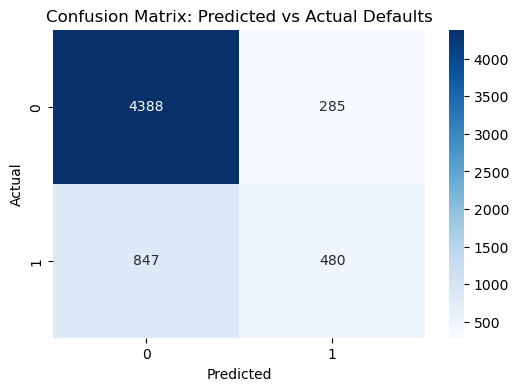

In [6]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Print the Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Predicted vs Actual Defaults')
plt.show()

/var/folders/fn/rws_121d54d1m8b3zg04_qhm0000gn/T/ipykernel_3223/2724721466.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


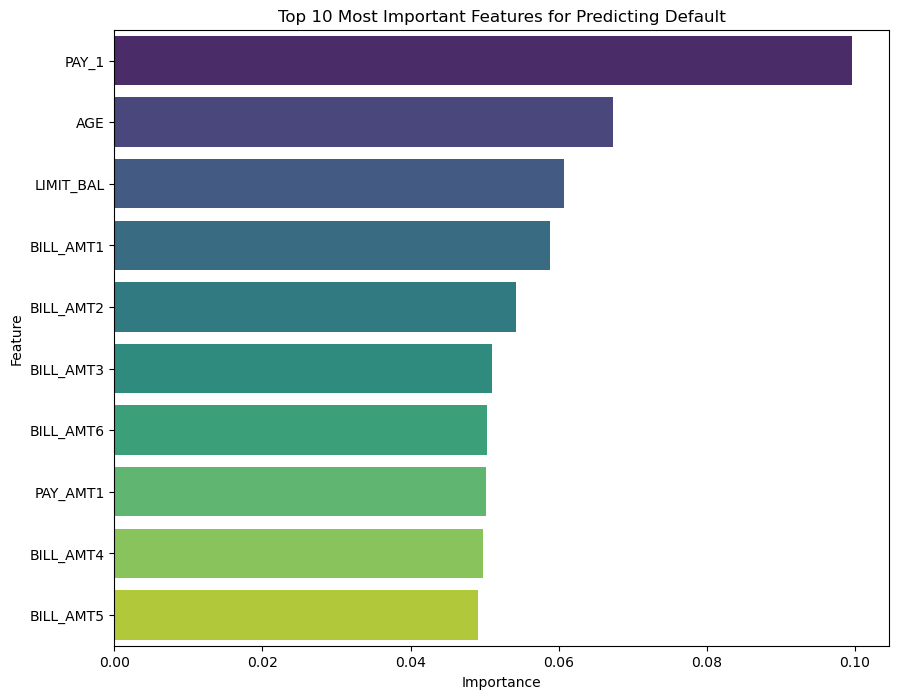

In [7]:
# Get feature importance from the model
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Default')
plt.show()

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check original class distribution
print(f"Original training dataset shape: {Counter(y_train)}")

# Initialize SMOTE
sm = SMOTE(random_state=42)

# Resample the training data
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print(f"Resampled training dataset shape: {Counter(y_train_res)}")

Original training dataset shape: Counter({0: 18691, 1: 5309})
Resampled training dataset shape: Counter({0: 18691, 1: 18691})


Classification Report (After SMOTE):
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      4673
           1       0.53      0.46      0.49      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000



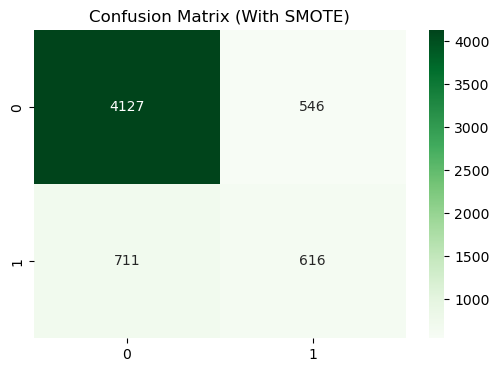

In [9]:
# Train the Random Forest again on the BALANCED data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_smote.fit(X_train_res, y_train_res)

# Predict on the (un-smoted) test set
y_pred_smote = rf_model_smote.predict(X_test_scaled)

# Evaluation
print("Classification Report (After SMOTE):")
print(classification_report(y_test, y_pred_smote))

# Compare with previous Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (With SMOTE)')
plt.show()

In [10]:
# 1. Get the probability of default (Class 1) for the entire dataset
# Note: We use the scaled features we prepared earlier
X_full_scaled = scaler.transform(X) # Scale the entire dataset
probabilities = rf_model_smote.predict_proba(X_full_scaled)[:, 1] # Get probability of default

# 2. Add the predictions and probabilities back to the original dataframe
df['Default_Probability'] = probabilities
df['Predicted_Default'] = (probabilities > 0.5).astype(int)

# 3. Create 'Risk Segments' based on probability
def get_risk_segment(prob):
    if prob < 0.3: return 'Low Risk'
    elif prob < 0.6: return 'Medium Risk'
    else: return 'High Risk'

df['Risk_Segment'] = df['Default_Probability'].apply(get_risk_segment)

print("Predictions and Risk Scores added to the dataset.")
display(df[['LIMIT_BAL', 'Default_Probability', 'Risk_Segment', 'DEF_PAY']].head())

Predictions and Risk Scores added to the dataset.


,LIMIT_BAL,Default_Probability,Risk_Segment,DEF_PAY
0,20000.0,0.90,High Risk,1
1,120000.0,0.37,Medium Risk,1
2,90000.0,0.11,Low Risk,0
3,50000.0,0.06,Low Risk,0
4,50000.0,0.09,Low Risk,0


In [11]:
# Save the final master file
final_output_path = '../data/processed/tableau_master_file.csv'
df.to_csv(final_output_path, index=False)

print(f"Master file for Tableau exported to: {final_output_path}")

Master file for Tableau exported to: ../data/processed/tableau_master_file.csv
